In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from tab_transformer_pytorch import FTTransformer

In [4]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is not available, using CPU instead


# LOAD AND PROCESS DATA
**EXAMPLE WITH California Sklearn DATASET**

In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/validation.csv') #READ FROM RIGHT SPOT

#Take a look at what the datasets look like initially to get an idea
df_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,1.261189,-0.764261,-0.358478,0.584211,0.643412,0.431828,0.688976,-0.627034,1.0,-0.786025
1,-0.906340,1.384381,0.355019,0.401362,0.681233,0.077837,0.741252,-0.993331,1.0,-0.764461
2,-1.425748,1.000528,1.861291,-0.415056,-0.361193,-0.698186,-0.372218,-0.104586,3.0,2.523613
3,0.581963,-0.689363,0.196464,0.115662,0.258117,0.173441,0.362254,-0.108109,0.0,1.104704
4,0.936559,-0.736174,0.037909,-0.620761,-0.599934,-0.179689,-0.476769,-0.674510,1.0,-0.630765
...,...,...,...,...,...,...,...,...,...,...
12254,0.806707,-0.904695,-0.358478,0.163202,-0.086995,0.010657,-0.118681,0.814126,0.0,0.569055
12255,1.021462,-0.885971,-1.864750,1.468283,1.177626,1.579069,1.313670,0.481794,0.0,-0.402187
12256,0.581963,-0.768942,1.068516,-0.475396,-0.396649,-0.407070,-0.356535,-0.410684,0.0,1.103841
12257,-1.225976,0.897543,-1.309808,1.410229,1.246175,1.732379,1.460041,0.740152,3.0,0.205055


In [6]:
def categorize_columns(dataframe):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            categorical_columns.append(column)
            unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    return categorical_columns, continuous_columns, unique_classes_per_column

In [7]:
target = 'median_house_value'

In [8]:
cat_cols, cont_cols, unique_classes_per_column = categorize_columns(df_train)

if target in cont_cols:
    cont_cols.remove(target)
elif target in cat_cols:
    cat_cols.remove(target)

print("Target:", target)
print("Categorical: ", cat_cols)
print("Continous: ", cont_cols)
print("Unique Classes per Column: ", unique_classes_per_column)


Target: median_house_value
Categorical:  ['ocean_proximity']
Continous:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Unique Classes per Column:  [5]


In [9]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_cols, cont_cols, 'median_house_value')
val_dataset = SingleTaskDataset(df_val, cat_cols, cont_cols, 'median_house_value')
test_dataset = SingleTaskDataset(df_test, cat_cols, cont_cols, 'median_house_value')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class LossFunctions(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunctions, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.MSELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
    total_r2_score = 0
    root_mean_squared_error_total = 0

    for (categorical, numerical, labels_task1) in dataloader:
        categorical, numerical, labels_task1 = categorical.to(device_in_use), numerical.to(device_in_use), labels_task1.to(device_in_use)
        
        #running them through model and modifying the shape slightly for the loss function
        task_predictions = model(categorical, numerical)
        task_predictions = task_predictions.squeeze(1)
        
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions)
        total_r2_score += r2

        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions)
        root_mean_squared_error_total+=rmse_value

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_loss = 0
  total_r2_score = 0
  root_mean_squared_error_total = 0

  with torch.no_grad():
    for (categorical, numerical, labels_task1) in dataloader:
        categorical, numerical, labels_task1 = categorical.to(device_in_use), numerical.to(device_in_use), labels_task1.to(device_in_use)
     
        task_predictions = model(categorical, numerical)
        task_predictions = task_predictions.squeeze(1)
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions)
        total_r2_score += r2
        
        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions)
        root_mean_squared_error_total+=rmse_value

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

def r2_score_manual(y_true, y_pred):
    # Calculate the mean of true labels
    y_mean = torch.mean(y_true)

    # Calculate the total sum of squares
    total_ss = torch.sum((y_true - y_mean)**2)

    # Calculate the residual sum of squares
    residual_ss = torch.sum((y_true - y_pred)**2)

    # Calculate R-squared
    r2 = 1 - (residual_ss / total_ss)

    return r2.item()  # Convert to a Python float

def rmse(y_true, y_pred):
    # Calculate the squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff)

    # Calculate the square root to obtain RMSE
    rmse = torch.sqrt(mean_squared_diff)

    return rmse.item()  # Convert to a Python float

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# RUN EXPERIMENTS

1. Using Optuna to optimize FT-Transformers hyperparameters for your dataset

Number of parameters:  1634689
Epoch [ 1/100]       | Train: Loss 0.7590, R2 0.2357, RMSE 0.8554                        | Test: Loss 0.4401, R2 0.5570, RMSE 0.6626
Epoch [ 2/100]       | Train: Loss 0.4044, R2 0.5935, RMSE 0.6343                        | Test: Loss 0.3459, R2 0.6490, RMSE 0.5869
Epoch [ 3/100]       | Train: Loss 0.3464, R2 0.6516, RMSE 0.5869                        | Test: Loss 0.3111, R2 0.6863, RMSE 0.5564
Epoch [ 4/100]       | Train: Loss 0.3259, R2 0.6722, RMSE 0.5691                        | Test: Loss 0.2959, R2 0.7031, RMSE 0.5431
Epoch [ 5/100]       | Train: Loss 0.3046, R2 0.6922, RMSE 0.5500                        | Test: Loss 0.2843, R2 0.7145, RMSE 0.5309
Epoch [ 6/100]       | Train: Loss 0.2946, R2 0.7028, RMSE 0.5415                        | Test: Loss 0.2742, R2 0.7240, RMSE 0.5220
Epoch [ 7/100]       | Train: Loss 0.2899, R2 0.7075, RMSE 0.5365                        | Test: Loss 0.2770, R2 0.7201, RMSE 0.5250
Epoch [ 8/100]       | Train: Loss 0.2

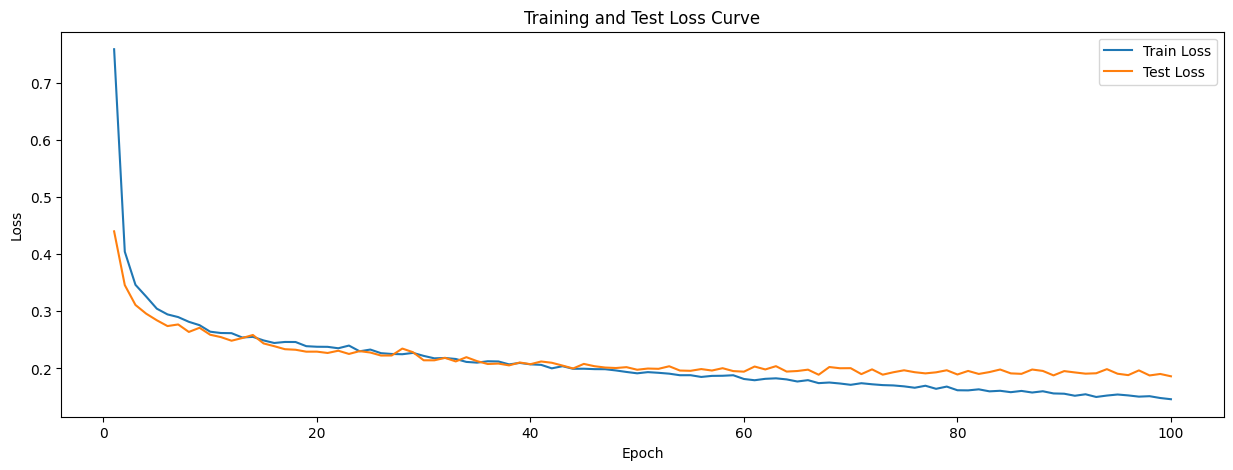

In [17]:
#Testing against the test dataset
model = FTTransformer(categories=tuple(unique_classes_per_column),
                          num_continuous=len(cont_cols),
                          dim=192,
                          depth=3,
                          heads=8,
                          dim_out=1,
                          attn_dropout=0.2,
                          ff_dropout=0.1).to(device_in_use)
loss_functions = LossFunctions(1)
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 0.0001, weight_decay=0.00001)
epochs = 100

print("Number of parameters: ", count_parameters(model))

lowest_mse = float('inf')
train_losses = []
test_losses = []

for t in range(epochs):
  train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, r2_test, rmse_test = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  
  # keep track of losses (MSE)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  
  if test_loss < lowest_mse:
    lowest_mse = test_loss

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, R2 {format_metric(r2_train)}, RMSE {format_metric(rmse_train)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, R2 {format_metric(r2_test)}, RMSE {format_metric(rmse_test)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


torch.save(model.state_dict(), 'ft_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

print("Lowest MSE: ", lowest_mse)
